# NEURAL STYLE TRANSFER
![title](./pics/style-transfer.png)

### Schematic formulation of a "style transfer" loss

conserve the "content" of the original image, while adopting the "style" of the reference image. If we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following

```
loss = distance(style(reference_image) - style(generated_image)) +
   distance(content(original_image) - content(generated_image))
```


- Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The convnet should "see" both the target image and the generated image as "containing the same things".

- Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Indeed, feature correlations capture textures: the generated and the style reference image should share the same textures at different spatial scales.

## Neural style transfer in Keras

In [12]:
#imports

#keras imports
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K

#general imports
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import numpy as np
import time
import cv2
import os

# visualiaztion imports
%matplotlib inline
import matplotlib.pyplot as plt

### Auxiliary functions

In [2]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
# This is the path to the image you want to transform.
target_image_path = './pics/target-image.jpg'
# This is the path to the style image.
style_reference_image_path = './pics/reference-image.jpg'
# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

print ("Final ouput shape will be: {}".format((img_height,img_width,3)))

Final ouput shape will be: (400, 533, 3)


## Loading the pre-trained VGG19 network and Loss definitions

In [4]:
## The loss that we minimize is a weighted average of these below three losses

def content_loss(base, combination):
    # The content loss, operating on the features of the 
    # target image and the generated "combination" image
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    # map of the correlations found in the feature matrix
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    # The style loss, operating on the features of the style 
    # reference image and the generated "combination" image
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # The total variation loss, operating on the pixels 
    # of the generated "combination" image
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

### Defining the final loss that we will minimize

In [5]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Name of layer used for content loss
content_layer = 'block5_conv2'

# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

### Setting up the gradient descent process

In [6]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
 
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### The style transfer loop

In [7]:
result_prefix = 'my_result'
iterations = 20
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,fprime=evaluator.grads, maxfun=20)
    
    print('Current loss value:', min_val)
    
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(os.path.join("pics",fname), img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 785713000.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 222s
Start of iteration 1


/Users/sanjyotzade/anaconda3/envs/francois/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 272375520.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 225s
Start of iteration 2
Current loss value: 168216620.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 218s
Start of iteration 3
Current loss value: 130612824.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 220s
Start of iteration 4
Current loss value: 113099510.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 223s
Start of iteration 5
Current loss value: 98599976.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 225s
Start of iteration 6
Current loss value: 89026530.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 221s
Start of iteration 7
Current loss value: 78742240.0
Image saved as my_result_at_iteration_7.png
Iteration 7 completed in 223s
Start of iteration 8
Current loss value: 71442940.0
Image saved as my_result_at_iteration_8.png
Iteration 8 completed in 232s
Start of 

### results

Text(0.5, 1.0, 'generated image after 20 epochs')

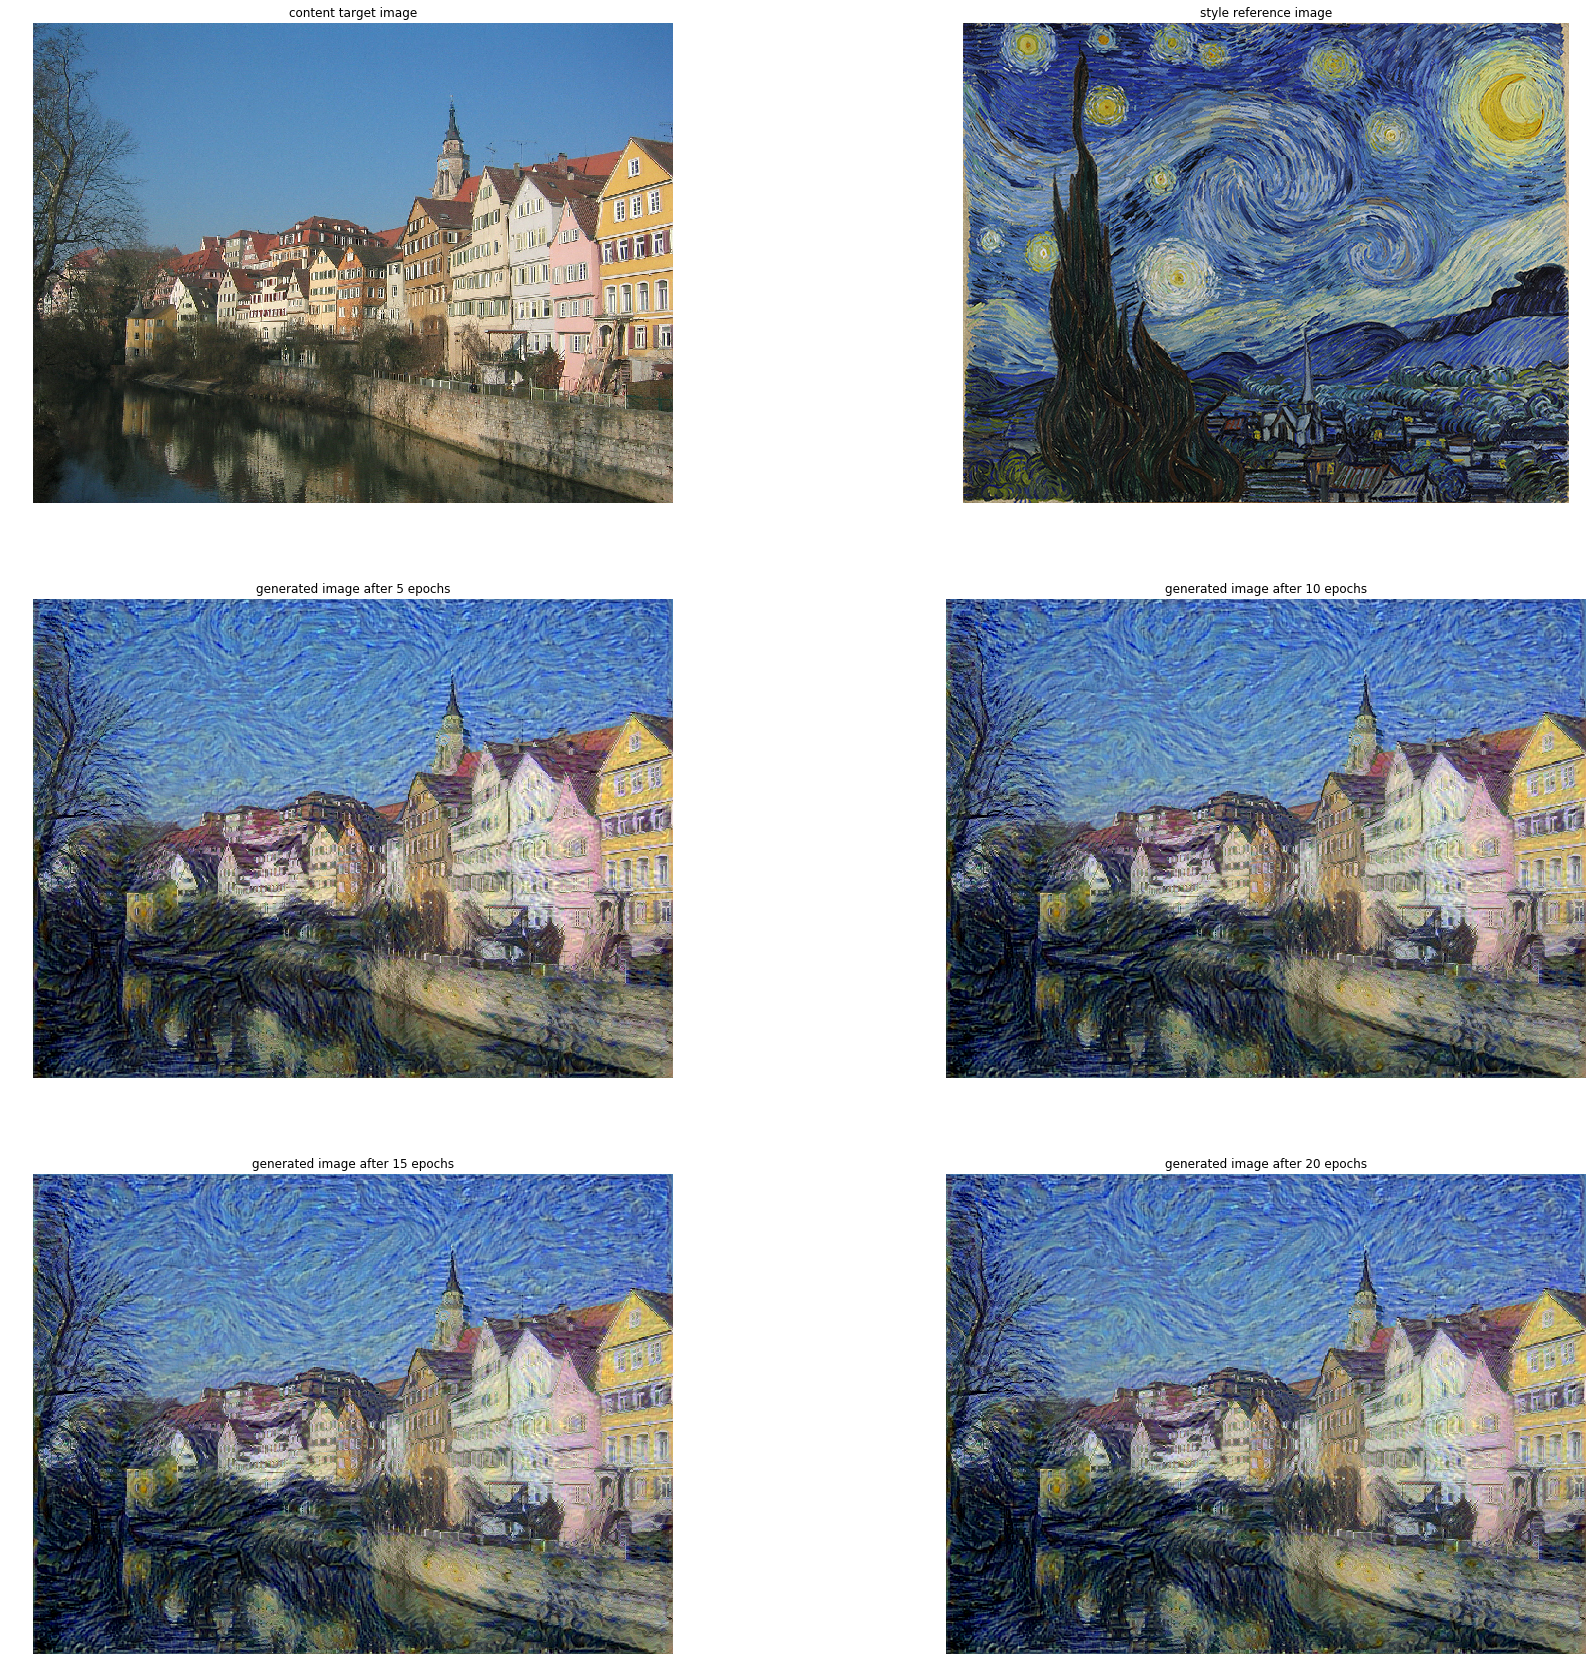

In [20]:
def read_image(path):
    return  cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(read_image("./pics/target-image.jpg"))
plt.axis('off')
plt.title("content target image")
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(read_image("./pics/reference-image.jpg"))
plt.axis('off')
plt.title("style reference image")
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(read_image("./pics/my_result_at_iteration_4.png"))
plt.axis('off')
plt.title("generated image after 5 epochs")
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(read_image("./pics/my_result_at_iteration_9.png"))
plt.axis('off')
plt.title("generated image after 10 epochs")
ax5 = fig.add_subplot(3,2,5)
ax5.imshow(read_image("./pics/my_result_at_iteration_14.png"))
plt.axis('off')
plt.title("generated image after 15 epochs")
ax6 = fig.add_subplot(3,2,6)
ax6.imshow(read_image("./pics/my_result_at_iteration_19.png"))
plt.axis('off')
plt.title("generated image after 20 epochs")